**ensemble**

- 여러 개의 모델(classifier)을 사용해서 예측 결합함으로써 
  보다 정확한 최종 예측을 도출하는 기법
  
    약한 애들 모아서 할건데 그걸 어떻게 할거야? 아래 방법들을 사용해서




- Voting : hard voting(여러 모델 중 다수결) 
           soft voting(결과를 평균)


- Bagging : 같은 유형의 모델을 병렬 결합(Bootstrapping aggregation)


- Boosting : 여러 개의 모델을 순차적으로 학습하여 결과에 대한 가중치를 부여

            (오답에 높은 가중치 -> 오답을 정답으로 맞추기 위해)

Voting, Boosting = 다른 모델
Bagging = 같은 모델 사용


- Stacking : 위의 여러개의 개별적 모델을 학습하여 예측한 데이터셋을 
             최종 메타 모델이 사용하여 결과 도출

대표적인 앙상블 알고리즘

- Random Forest : decision tree가 여러개(bagging)
- Gradient Boosting : 이전 트리의 오차 보완(boosting)
- XGBoost / LightGBM


예측과 분류를 잘 못해서 score가 낮은 애들을 모아서 좋은 결과를 만들자

voting - a,b,c라는 모델이 결과 예측했는데 
         다수결로 c모델하자 하면 hard voting, 결과 평균내자 하면 soft voting
         
bagging - a(1/3),a(1/3),a(1/3) 모델이 데이터를 잘라서 샘플링한 데이터가 다른걸 학습하는게
병렬이라 속도가 빠르다

boosting - a->b->c    a가 학습한거 b가 받고,b가 학습한걸 c가 받는다  
           이전모델의 학습 결과를 가지고 다음에서 결과를 만든다. 
           그래서 이상치 영향을 많이받는다는 단점이 있다. a이상치를 가지고 b, c가 분석을 하니까
           
                      

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
mr = pd.read_csv("../datasets/mushrooms.csv")
mr

,type,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [6]:
mr.info()
# info 데이터에 대한 전반적인 정보를 나타냅니다. df를 구성하는 행과 열의 크기, 컬럼명, 컬럼을 구성하는 값의 자료형 등을 출력해줍니다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   type                      8124 non-null   object
 1   cap_shape                 8124 non-null   object
 2   cap_surface               8124 non-null   object
 3   cap_color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill_attachment           8124 non-null   object
 7   gill_spacing              8124 non-null   object
 8   gill_size                 8124 non-null   object
 9   gill_color                8124 non-null   object
 10  stalk_shape               8124 non-null   object
 11  stalk_root                8124 non-null   object
 12  stalk_surface_above_ring  8124 non-null   object
 13  stalk_surface_below_ring  8124 non-null   object
 14  stalk_color_above_ring  

In [7]:
# e : (edible 식용)
# p : (poisonous 독)
mr.iloc[:, 0].value_counts()

# iloc[:, 0]  = 전체행 0번지열    type 
# .value_counts()  =  iloc[:, 0]의 항목 중 중첩들을 하나씩 표기 후 갯수를 적어준다. 
# e    4208   
# p    3916
# 여기엔 식용과 독 두 가지로 구분이 되어 있는데, 그 수는 위와 같다.

# dtype이 다 object로 되어있다? = > "문자열"이다
#  문자열은 학습시킬 수 없는데?
# 그래서 이걸 숫자로 바꿔줄게  (밑에)

type
e    4208
p    3916
Name: count, dtype: int64

In [8]:
ord("a")
# 아스키코드로 바꿔줬어 그래서 얘 숫자야~~  ascii 

97

In [10]:
# chr(ord("a"))
chr(97)
# 이건 아스키코드를 다시 문자열로 바꿔주는 식이야  둘 다 가능한 식

# 이건 그냥 이런게 있다 하고 넘어간건가?

'a'

In [11]:
mr.iterrows()
# generator 호출했을 때 일드 만나서 하나만 가져오는 애

<generator object DataFrame.iterrows at 0x00000145395C3610>

In [13]:
x = list()
y = list()

for idx, row in mr.iterrows():
    y.append(row.iloc[0])
    
    row_data = list()
    for data in row.iloc[1:]:
        row_data.append(ord(data))
    x.append(row_data)
#     print(f"{idx}:{row}")
#     break

#iterrows하니까 아래 애들이 들어가있다. 시리즈로 가져온다(지금은 주석처리함  break부분)
# 0번지에 있는 녀석은 y로 지정해주면 될 것 같고
# 나머지는 x로 지정하면 될 것 같다.
# 독버섯인지 식용버섯인지 

In [14]:
print(x)
print(y)
# []= p[]=e[]=e[]=p[]=e   p는 독 e는 식용

[[120, 115, 110, 116, 112, 102, 99, 110, 107, 101, 101, 115, 115, 119, 119, 112, 119, 111, 112, 107, 115, 117], [120, 115, 121, 116, 97, 102, 99, 98, 107, 101, 99, 115, 115, 119, 119, 112, 119, 111, 112, 110, 110, 103], [98, 115, 119, 116, 108, 102, 99, 98, 110, 101, 99, 115, 115, 119, 119, 112, 119, 111, 112, 110, 110, 109], [120, 121, 119, 116, 112, 102, 99, 110, 110, 101, 101, 115, 115, 119, 119, 112, 119, 111, 112, 107, 115, 117], [120, 115, 103, 102, 110, 102, 119, 98, 107, 116, 101, 115, 115, 119, 119, 112, 119, 111, 101, 110, 97, 103], [120, 121, 121, 116, 97, 102, 99, 98, 110, 101, 99, 115, 115, 119, 119, 112, 119, 111, 112, 107, 110, 103], [98, 115, 119, 116, 97, 102, 99, 98, 103, 101, 99, 115, 115, 119, 119, 112, 119, 111, 112, 107, 110, 109], [98, 121, 119, 116, 108, 102, 99, 98, 110, 101, 99, 115, 115, 119, 119, 112, 119, 111, 112, 110, 115, 109], [120, 121, 119, 116, 112, 102, 99, 110, 112, 101, 101, 115, 115, 119, 119, 112, 119, 111, 112, 107, 118, 103], [98, 115, 121, 11

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [16]:
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
# n_estimators는 모델(decision tree)의 갯수  (모델을 몇개 쓰는지)
# estimators은 모델을 의미한다. 

#  RandomForest 똑같은 모델 모아서 잘러서 각각 데이터학습하게 한다.
#  트리라서 포레스트 decision tree의 갯수
# max_depth=5  나무의 깊이 질문의 갯수
# n_jobs : 병렬처리할 CPU 갯수 (-1 : CPU 전체)

In [17]:
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=-1)

In [19]:
predict = model.predict(x_test)
accuracy_score(y_test, predict)
# 결과가 높게 나왔다.

0.9876923076923076

In [20]:
print(classification_report(y_test, predict))
# 어떤 모델을 썼나? 우리 decision tree를 사용했으니 RandomForestClassifier

              precision    recall  f1-score   support

           e       0.98      1.00      0.99       820
           p       1.00      0.98      0.99       805

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



In [23]:
model.estimator_

DecisionTreeClassifier()

In [24]:
model.estimators_

[DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=352394653),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1333020726),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=912483532),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1302498857),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=402764503),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=625044634),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1303425997),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1915082749),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=831044405),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1687761823),
 DecisionTreeClassifier(max_depth=5, max_feat

In [25]:
from sklearn.tree import plot_tree

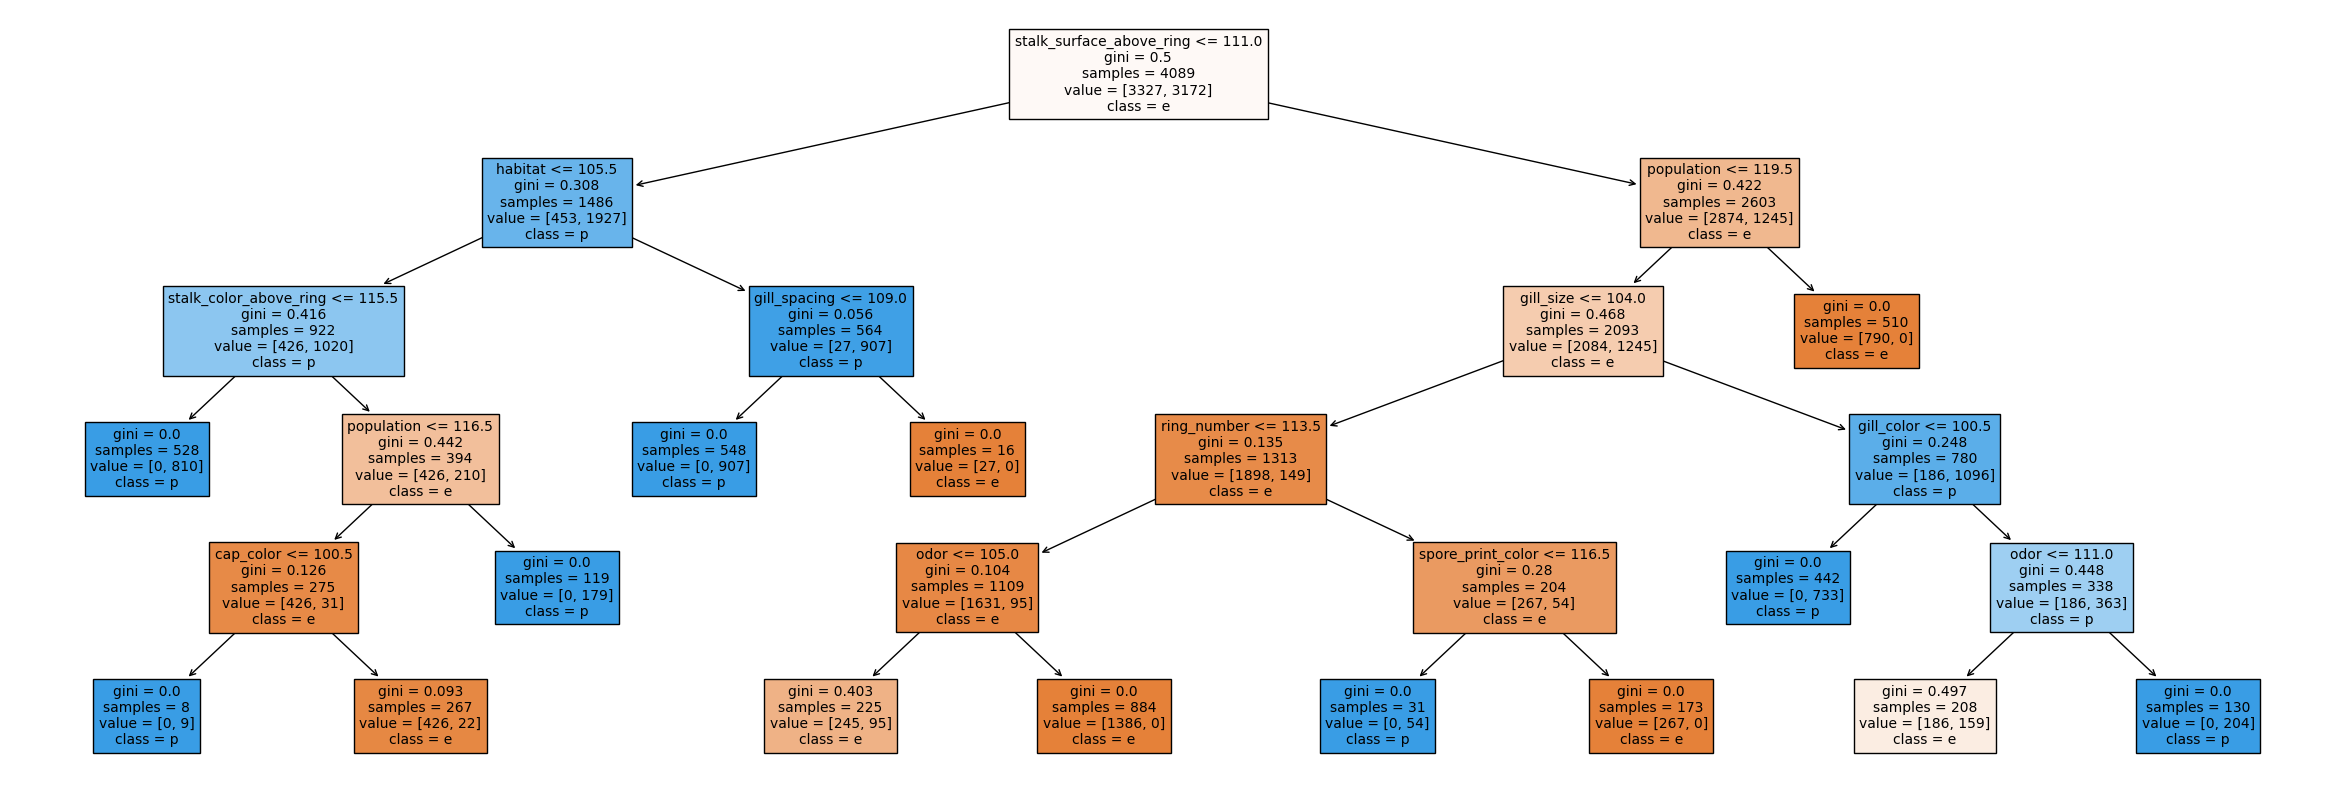

In [26]:
estimator = model.estimators_[0]
plt.figure(figsize=(30, 10))
plot_tree(estimator, class_names=["e","p"],
         feature_names=list(mr.columns[1:]),
         filled=True, fontsize=10)
plt.show()

In [ ]:
#  진할수록 지니 계수가 낮고 해당 레이블에 속하는 샘플 데이터가 많다는 뜻
# 파랑주황이 true false